<span style = "color:blue; font-size:24px">DecisionTree</span>

This notebook only focuses on Decision Tree model training.

ZeekData24 Attack Profiles 

Dataset 1: Multiple Attack Types 

Dataset 2: Multiple Attack Types 

Dataset 3: Multiple Attack Types 

Dataset 4: Multiple Attack Types 

Dataset 5: Multiple Attack Types 

Datest 6: Benign Data 

Dataset 7: Benign Data


Combine All Datasets and Exclude any attacks not being currently used for training

In [1]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize Spark session
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log") \
                            .master("spark://192.168.1.2:7077") \
                            .config("spark.driver.cores", "2") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "12g") \
                            .config("spark.executor.cores", "3") \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

#Paths containing network data
data_paths = [
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet"
            ]
# Predefined list of MITRE ATT&CK labels
mitre_labels = [
    "Privilege Escalation", "Execution", "Persistence", "Defense Evasion",
    "Credential Access", "Discovery", "Lateral Movement", "Collection",
    "Exfiltration", "Command and Control", "Impact", "Reconnaissance", "Resource Development"
]

# Container to hold the processed DataFrames
df_list = []

# Counter variable
j = 0

# Loop through each path, load and process the data
for path in data_paths:
    # Load each dataset
    df = spark.read.parquet(path)
   
    # Select relevant columns
    df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
   
    #Show all rows of attack labels before any preprocessing
    print(f"Dataset {j+1}: All rows of 'label_tactic' before preprocessing:")
    all_label_tactics = df.select("label_tactic").distinct().collect()
    for row in all_label_tactics:
        print(row['label_tactic'])
              
    # Handle missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0,
        "label_tactic": "none"  # Default to 'none'
    })

    # Print unique count for each tactic type
    print(f"Dataset {j+1}: Unique count for each 'label_tactic' value before conversion")
    unique_tactic_counts = df.groupBy("label_tactic").count().orderBy(F.desc("count"))
    unique_tactic_counts.show(truncate=False)
   
    # Convert 'label_tactic' to binary: 'none' -> 0, anything else -> 1
    df = df.withColumn("label_tactic_binary", F.when(F.col("label_tactic") == "none", 0).otherwise(1))

    # Show the first few rows after binary conversion to verify
    print(f"First few rows after binary encoding:")
    df.select("label_tactic", "label_tactic_binary").show(5, truncate=False)

    # Convert 'label_tactic' to list of attack types for encoding
    df = df.withColumn("label_tactic_split", F.split("label_tactic", ","))
   
    # Perform MultiLabel encoding (before aggregation)
    df = df.withColumn("label_tactic_binary_encoded", F.expr(
        "array(" + ",".join([f"IF(array_contains(label_tactic_split, '{label}'), 1, 0)" for label in mitre_labels]) + ")"
    ))

    # Show the first few rows of 'label_tactic_binary_encoded' to check encoding
    print(f"First few rows of 'label_tactic_binary_encoded' (encoded attack types):")
    df.select("label_tactic", "label_tactic_split", "label_tactic_binary_encoded").show(5, truncate=False)

    #Time window 
    # Convert 'ts' to a timestamp
    df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
   
    # Aggregate data within time windows
    window_size = "1 seconds"
    stride = "0 minutes"  # Remove overlap
    
    df_agg = df.groupBy(F.window("ts", window_size)) \
        .agg(
            F.sum("orig_bytes").alias("sum_orig_bytes"),
            F.sum("resp_bytes").alias("sum_resp_bytes"),
            F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
            F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
            F.count("*").alias("connection_count"),
            F.max("label_tactic_binary").alias("label_tactic_binary_agg"),
            F.collect_set("label_tactic_split").alias("label_tactic_split_agg"),
            F.max("label_tactic_binary_encoded").alias("label_tactic_binary_encoded_agg")
        )

    # Flatten the window structure
    df_agg_flat = df_agg.select(
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "sum_orig_bytes",
        "sum_resp_bytes",
        "sum_orig_ip_bytes",
        "sum_resp_ip_bytes",
        "connection_count",
        "label_tactic_binary_agg",
        "label_tactic_split_agg",
        "label_tactic_binary_encoded_agg"
    )

    # Sort by window start time
    df_agg_sorted = df_agg_flat.orderBy("window_start")
   
    # Convert Spark DataFrame to Pandas for further analysis
    df_pandas_sorted = df_agg_sorted.toPandas()

    # Log-transform only (no normalization)
    df_pandas_sorted["sum_orig_bytes_log"] = np.log1p(df_pandas_sorted["sum_orig_bytes"])

    # Print the number of rows
    print(f"DataFrame for: {path} has total rows: {len(df_pandas_sorted)}")

    # Print unique 'label_tactic_split_agg' values
    print(f"Dataset {j+1}: Unique 'label_tactic_split_agg' values")
    unique_label_tactic_agg = df_agg_sorted.select("label_tactic_split_agg").distinct().collect()
    for row in unique_label_tactic_agg:
        print(row['label_tactic_split_agg'])

    # Add to DataFrame List
    df_list.append(df_pandas_sorted)

    #Indicate data finished loading
    print(f"Dataset {j+1} loaded successfully")

    j += 1

25/01/28 14:03:57 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.112 instead (on interface ens33)
25/01/28 14:03:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 14:03:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/28 14:03:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Dataset 1: All rows of 'label_tactic' before preprocessing:


Privilege Escalation
Reconnaissance
Credential Access
Persistence
Initial Access
Exfiltration
Defense Evasion
Dataset 1: Unique count for each 'label_tactic' value before conversion


+--------------------+------+
|label_tactic        |count |
+--------------------+------+
|Credential Access   |236706|
|Reconnaissance      |12762 |
|Initial Access      |2172  |
|Privilege Escalation|1251  |
|Persistence         |1251  |
|Defense Evasion     |1251  |
|Exfiltration        |50    |
+--------------------+------+

First few rows after binary encoding:
+--------------------+-------------------+
|label_tactic        |label_tactic_binary|
+--------------------+-------------------+
|Defense Evasion     |1                  |
|Initial Access      |1                  |
|Persistence         |1                  |
|Privilege Escalation|1                  |
|Defense Evasion     |1                  |
+--------------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+--------------------+----------------------+---------------------------------------+
|label_tactic        |label_tactic_split    |label_tactic_bin

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet has total rows: 17995
Dataset 1: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Credential Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['In

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet has total rows: 3554
Dataset 2: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Credential Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Initial Access']]
[['Reconnaissance'], ['Initial Access'], ['Credential Access']]
Dataset 2 loaded successfully
Dataset 3: All rows of 'label_tactic' before preprocessing:
Privilege Escalation
Reconnaissance
Credential Access
Persistence
Initial Access
Exfiltration
Defense Evasion
Dataset 3: Unique count for each 'label_tactic' value befo

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet has total rows: 12366
Dataset 3: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconn

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet has total rows: 27523
Dataset 4: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Cre

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet has total rows: 7474
Dataset 5: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Credential Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation'], ['Credential Access']]
[[

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet has total rows: 98456
Dataset 6: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 6 loaded successfully
Dataset 7: All rows of 'label_tactic' before preprocessing:
none
Dataset 7: Unique count for each 'label_tactic' value before conversion
+------------+------+
|label_tactic|count |
+------------+------+
|none        |503263|
+------------+------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0,

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet has total rows: 107369
Dataset 7: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 7 loaded successfully


In [2]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

# Combine the selected datasets for training and testing
df_train = pd.concat([df_list[4], df_list[6]], ignore_index=True)
df_test = pd.concat([df_list[3], df_list[5]], ignore_index=True)

# Define the features (X) and the target (y)
feature_columns = [
    "sum_orig_bytes_log", "sum_resp_bytes", "sum_orig_ip_bytes", 
    "sum_resp_ip_bytes", "connection_count"
]
target_column = "label_tactic_binary_agg"

# Prepare the training data
X_train = df_train[feature_columns]
y_train = df_train[target_column]

# Prepare the test data
X_test = df_test[feature_columns]
y_test = df_test[target_column]

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # You can adjust max_depth

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Attack", "Attack"]))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

   No Attack       0.99      1.00      1.00     98456
      Attack       1.00      0.98      0.99     27523

    accuracy                           1.00    125979
   macro avg       1.00      0.99      0.99    125979
weighted avg       1.00      1.00      1.00    125979

Accuracy Score: 0.9950388556822962
Confusion Matrix:
[[98447     9]
 [  616 26907]]


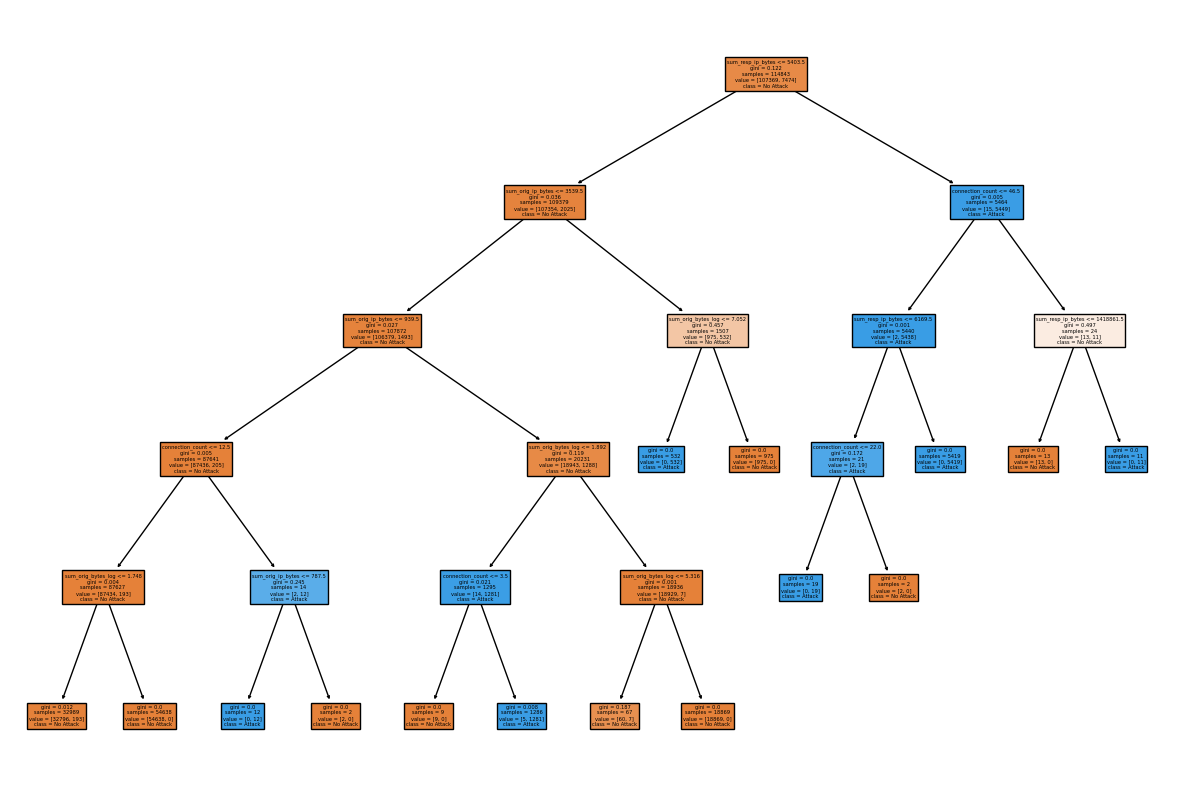

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, feature_names=feature_columns, class_names=["No Attack", "Attack"], filled=True)
plt.show()


In testing, Gini of 0.0 indicates there are no node impurities. Samples count of 40 with value of 1.0 shows all 40 samples in this leaf node belong to the attack class based on the binary attack classifiction of 1 being attack and 0 being no attack.